# Zillow Home Value Index

Dataset: https://www.kaggle.com/datasets/robikscube/zillow-home-value-index/data

## Business Understanding

We are given a dataset with the Zillow Home Value Index (ZHVI), and we want to help answer a few questions:

- Which states will have the greatest/smallest increase in price for next the next 5 years?
- Which states have home prices that have changed the most/least over time?

## Data Understanding

### Imports

In [352]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from itertools import cycle

from sklearn.linear_model import LinearRegression

### View Data

In [353]:
df = pd.read_csv("zillow_home_value_index/ZHVI.csv")

In [354]:
df.head()

,Unnamed: 0,Virginia,California,Florida,New York,New Jersey,Texas,Michigan,Massachusetts,Arizona,...,Kentucky,Missouri,Kansas,Delaware,Wyoming,Oklahoma,South Dakota,Nebraska,Iowa,Ohio
0,2000-01-01,122268.193859,186449.090913,105939.099867,150532.342593,167433.047753,111018.278532,113111.645859,191582.679106,133988.259586,...,84366.296586,94511.431926,86000.758305,144664.050906,NaN,79848.729013,106141.501276,112363.747584,88148.695499,103304.588561
1,2000-02-01,122584.578966,187075.801959,106168.573819,151068.385602,167884.388497,111078.608733,113173.945053,192222.309941,134230.951715,...,84409.854490,94622.206606,86017.640416,144889.114969,NaN,79881.666817,105915.985652,112543.365679,88317.143517,103367.717036
2,2000-03-01,122920.021448,187922.015335,106446.741990,151584.413444,168315.047081,111107.869825,113402.026693,192983.369702,134543.300942,...,84489.106316,94788.054284,86117.100292,145169.339985,NaN,80035.200471,105600.393222,112709.838619,88476.165508,103463.454714
3,2000-04-01,123553.896176,189758.892258,107012.186335,152694.249050,169269.184924,111253.095221,113856.364422,194482.336514,135181.100062,...,84686.054351,95167.144850,86265.785885,145810.208250,NaN,80314.777206,105175.008474,112968.255134,88819.648656,103744.975977
4,2000-05-01,124165.832795,191893.984972,107621.957129,153842.532171,170241.853435,111347.145464,114526.379974,196104.894267,135904.054386,...,84947.803755,95656.819992,86489.916103,146541.147029,NaN,80690.292238,104998.035988,113099.300600,89199.144497,104174.225895


In [355]:
df.shape

(300, 52)

In [356]:
df.isnull().sum()

Unnamed: 0                    0
Virginia                      0
California                    0
Florida                       0
New York                      0
New Jersey                    0
Texas                         0
Michigan                      0
Massachusetts                 0
Arizona                       1
Washington                    0
Colorado                      0
Illinois                      0
the District of Columbia      0
Nevada                        0
Hawaii                        0
New Hampshire                 0
Utah                          0
Georgia                       0
Montana                      61
Minnesota                     0
Louisiana                     0
Maryland                      0
Pennsylvania                  0
South Carolina                0
North Carolina                0
Vermont                       0
Tennessee                     0
Oregon                        0
New Mexico                   27
Rhode Island                  0
Alaska  

A few states have missing data, with North Dakota missing about a third of the data that most other states have. We won't delete any states since there is still a lot of data even for states with missing values. Let's just fill in those dates with bfill and ffill later on.

## Data Preparation

### Clean Up Columns

In [357]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

string_columns = list(df.dtypes[df.dtypes == "object"].index)
for column in string_columns:
    df[column] = df[column].str.lower().str.replace(" ", "_")
    
df.rename(columns={"unnamed:_0": "date"}, inplace=True)
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

df = df.bfill().ffill()

states = df.dtypes[df.dtypes == "float"].index

for state in states:
    df[state] = round(df[state], 2)

In [358]:
df.head()

,virginia,california,florida,new_york,new_jersey,texas,michigan,massachusetts,arizona,washington,...,kentucky,missouri,kansas,delaware,wyoming,oklahoma,south_dakota,nebraska,iowa,ohio
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,122268.19,186449.09,105939.10,150532.34,167433.05,111018.28,113111.65,191582.68,133988.26,171952.71,...,84366.30,94511.43,86000.76,144664.05,143432.94,79848.73,106141.50,112363.75,88148.70,103304.59
2000-02-01,122584.58,187075.80,106168.57,151068.39,167884.39,111078.61,113173.95,192222.31,134230.95,172340.58,...,84409.85,94622.21,86017.64,144889.11,143432.94,79881.67,105915.99,112543.37,88317.14,103367.72
2000-03-01,122920.02,187922.02,106446.74,151584.41,168315.05,111107.87,113402.03,192983.37,134543.30,172736.23,...,84489.11,94788.05,86117.10,145169.34,143432.94,80035.20,105600.39,112709.84,88476.17,103463.45
2000-04-01,123553.90,189758.89,107012.19,152694.25,169269.18,111253.10,113856.36,194482.34,135181.10,173534.77,...,84686.05,95167.14,86265.79,145810.21,143432.94,80314.78,105175.01,112968.26,88819.65,103744.98
2000-05-01,124165.83,191893.98,107621.96,153842.53,170241.85,111347.15,114526.38,196104.89,135904.05,174406.31,...,84947.80,95656.82,86489.92,146541.15,143432.94,80690.29,104998.04,113099.30,89199.14,104174.23


Now the data in the table is all cleaned up, and easier to work with.

### View Plots

Let's look at the trend of prices for each state using histograms and nice colors:

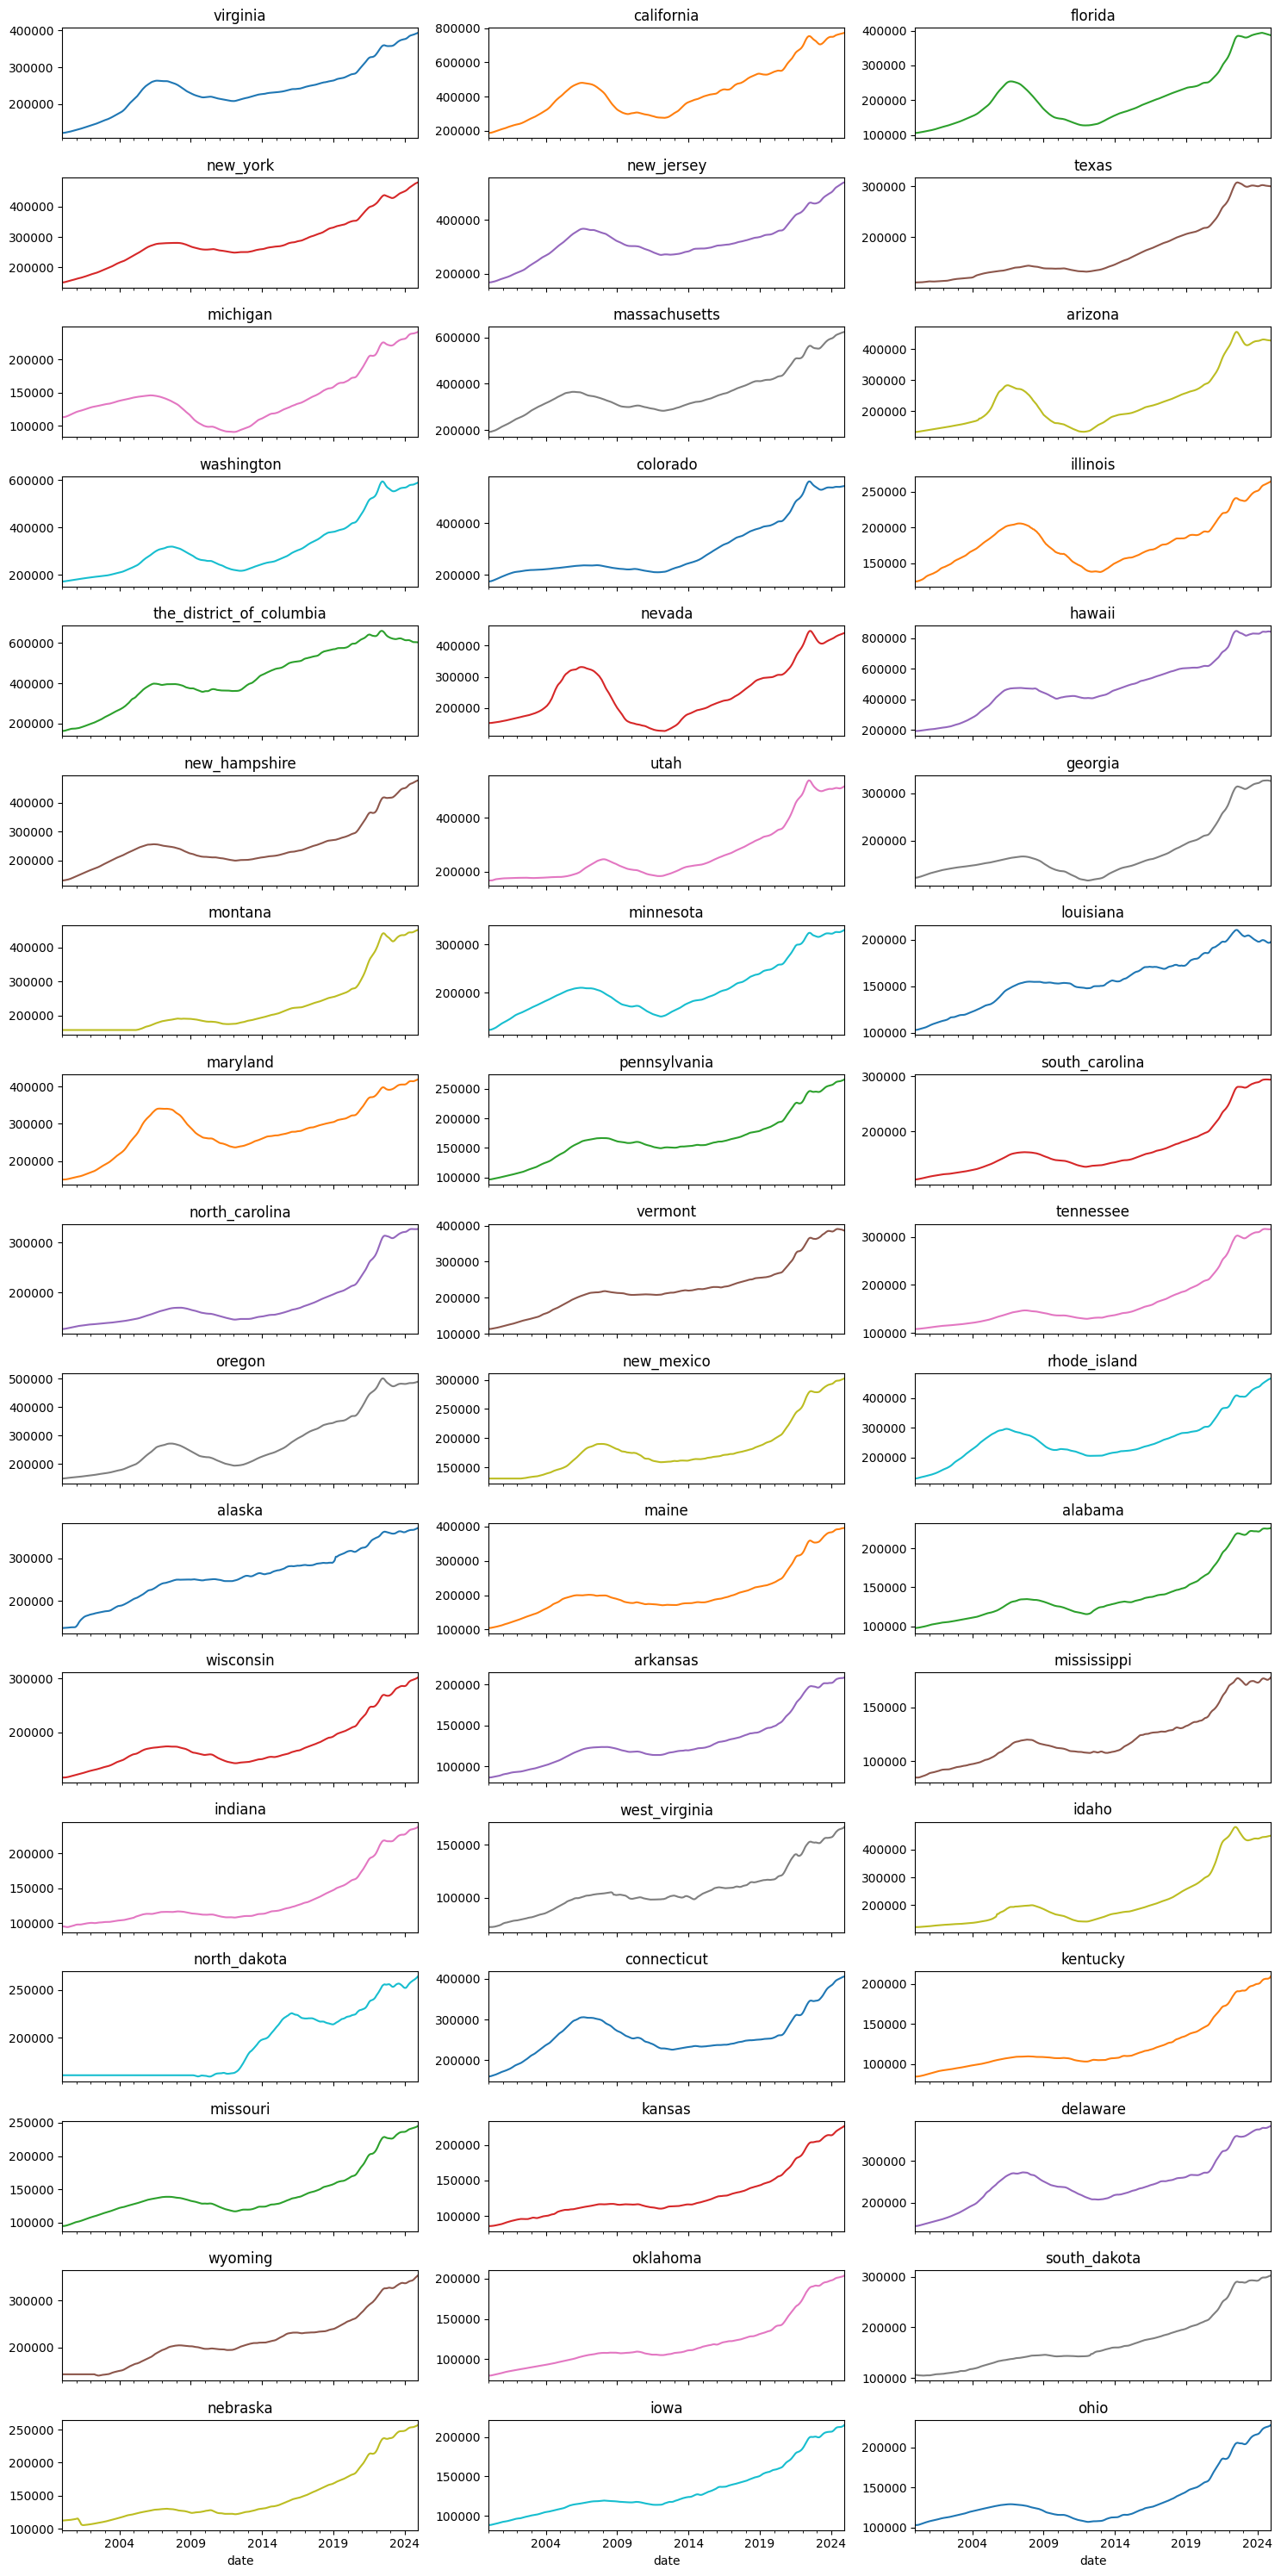

In [359]:
colors = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])  # this is a collection of 10 colors that repeats until you need them to

fig, axs = plt.subplots(17, 3, figsize=(15, 30), sharex=True, sharey=False)
axs = axs.flatten()

for i in range(len(states)):
    df[states[i]].plot(title=states[i], color=next(colors), ax=axs[i])

plt.tight_layout()
plt.show()

We see that price houses generally went up for each state. Some states even saw their home price double or more over this time span.

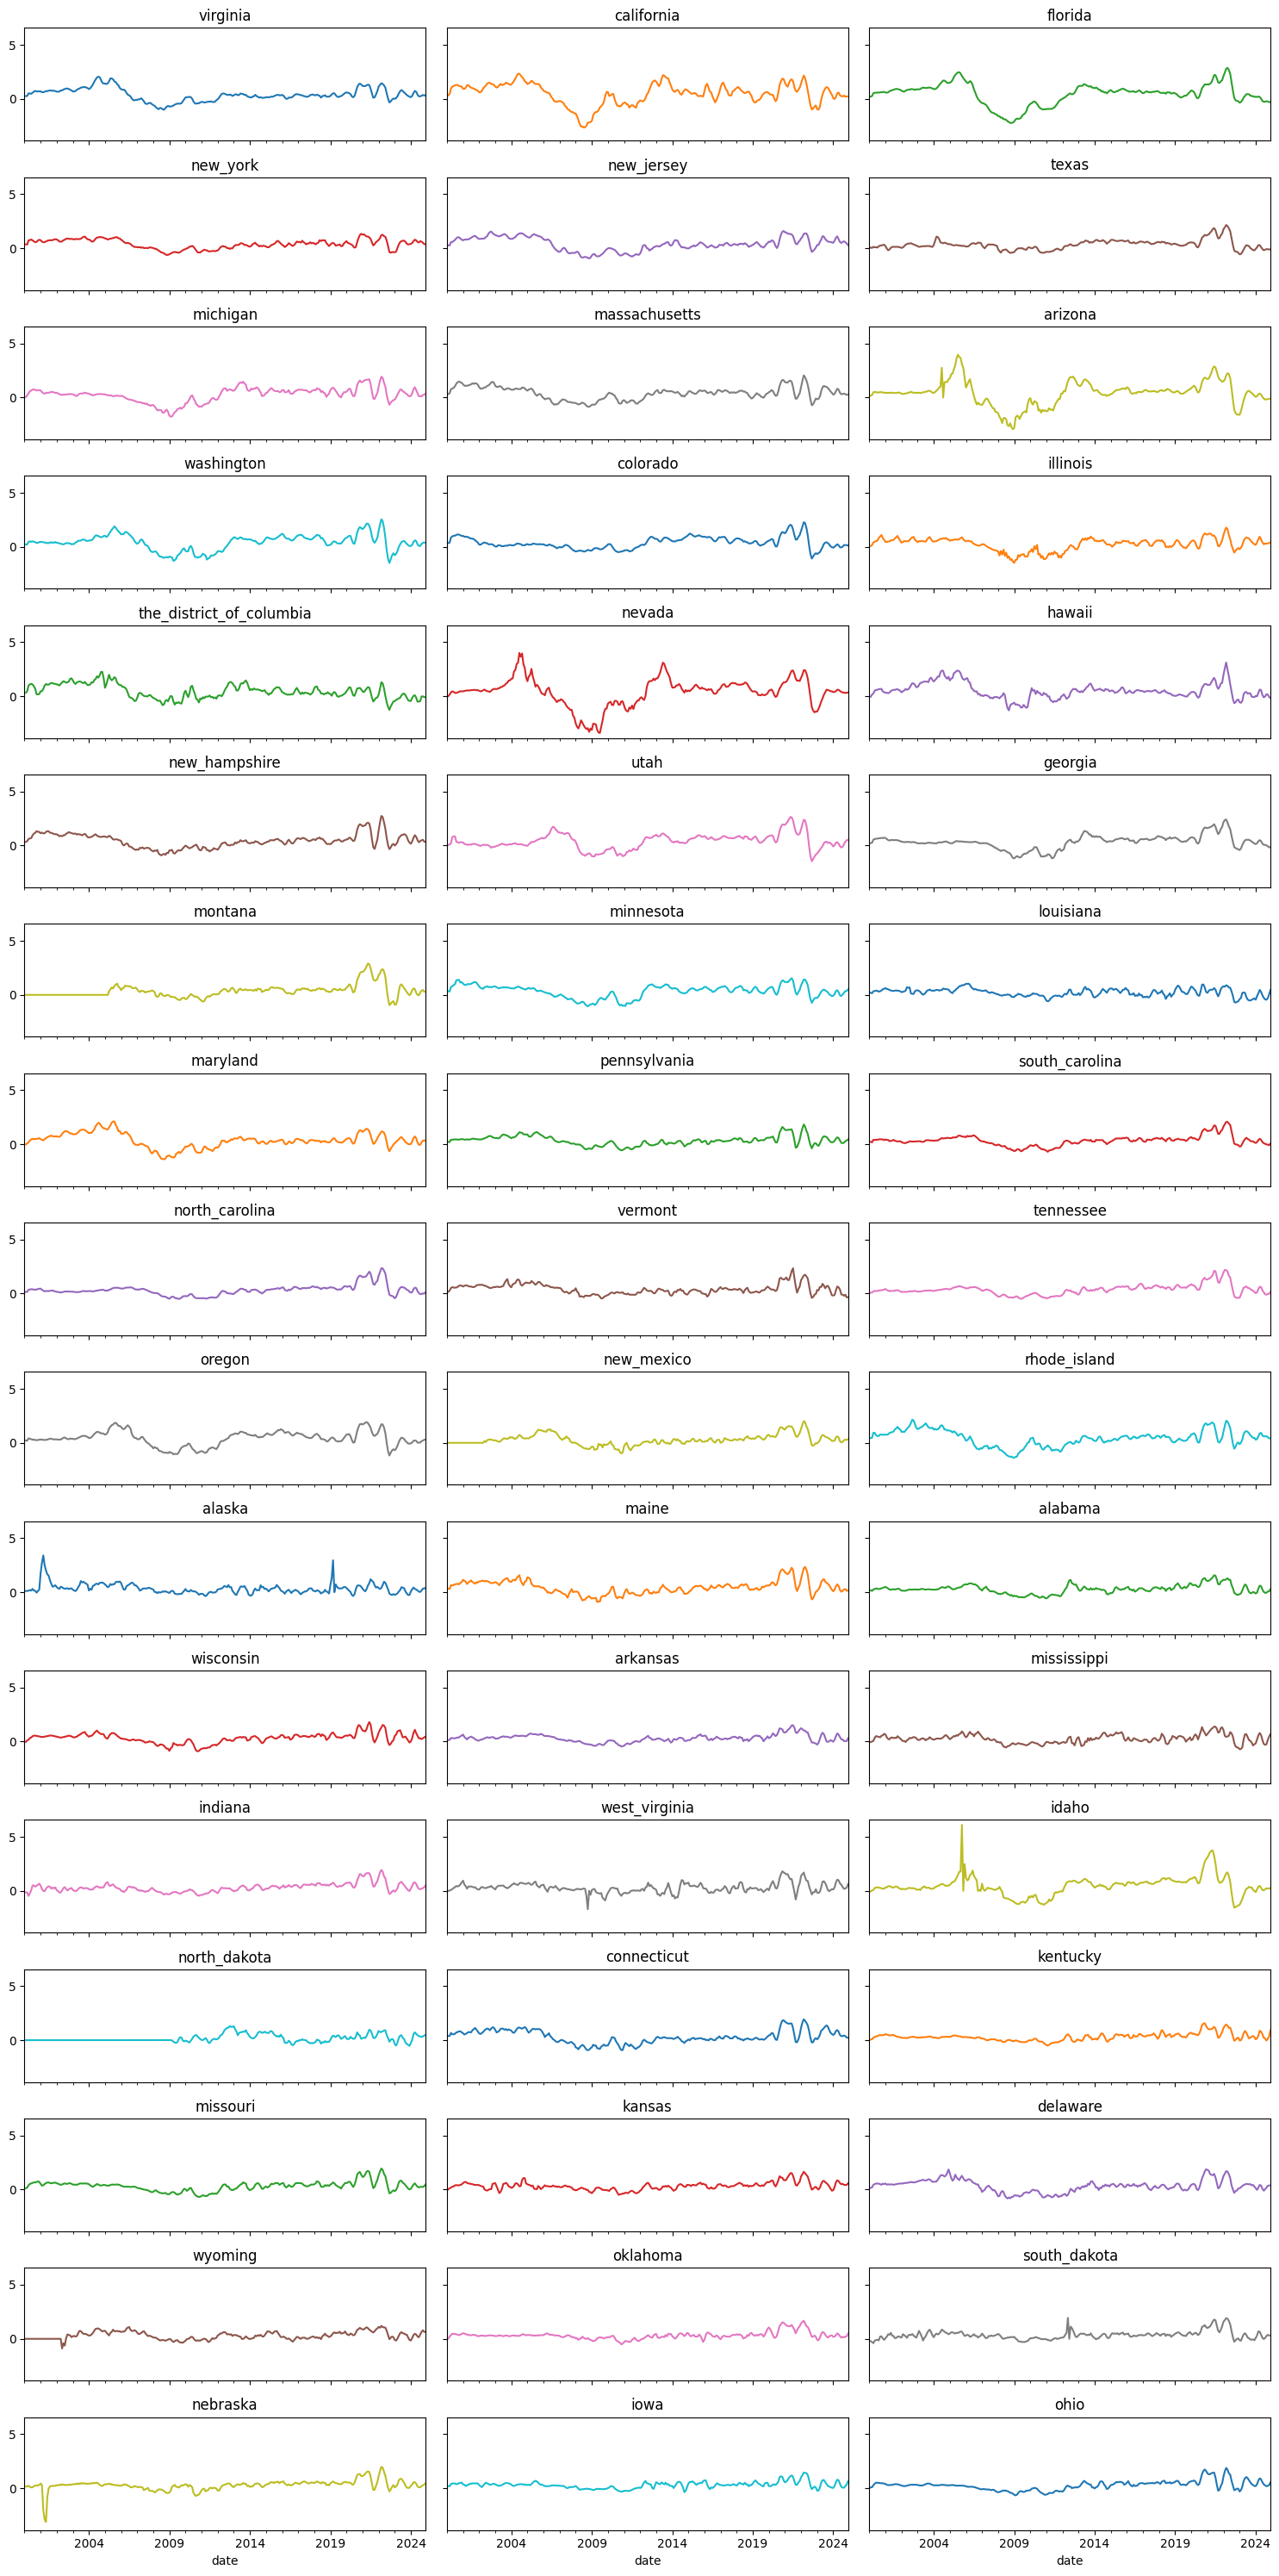

In [360]:
states = df.dtypes[df.dtypes == "float"].index
colors = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

fig, axs = plt.subplots(17, 3, figsize=(15, 30), sharex=True, sharey=True)
axs = axs.flatten()

for i in range(len(states)):
    (df[states[i]].pct_change() * 100).plot(title=states[i], color=next(colors), ax=axs[i])

plt.tight_layout()
plt.show()

We see that most states don't have much change year-over-year, so their growth is slow and steady.

## Modeling

### Future Forecast

Now, let's estimate what the next 5 years for each state will look like.

In [361]:
def add_months(start_date, months):
    return pd.date_range(start=start_date, periods = months + 1, freq="MS")[1:]

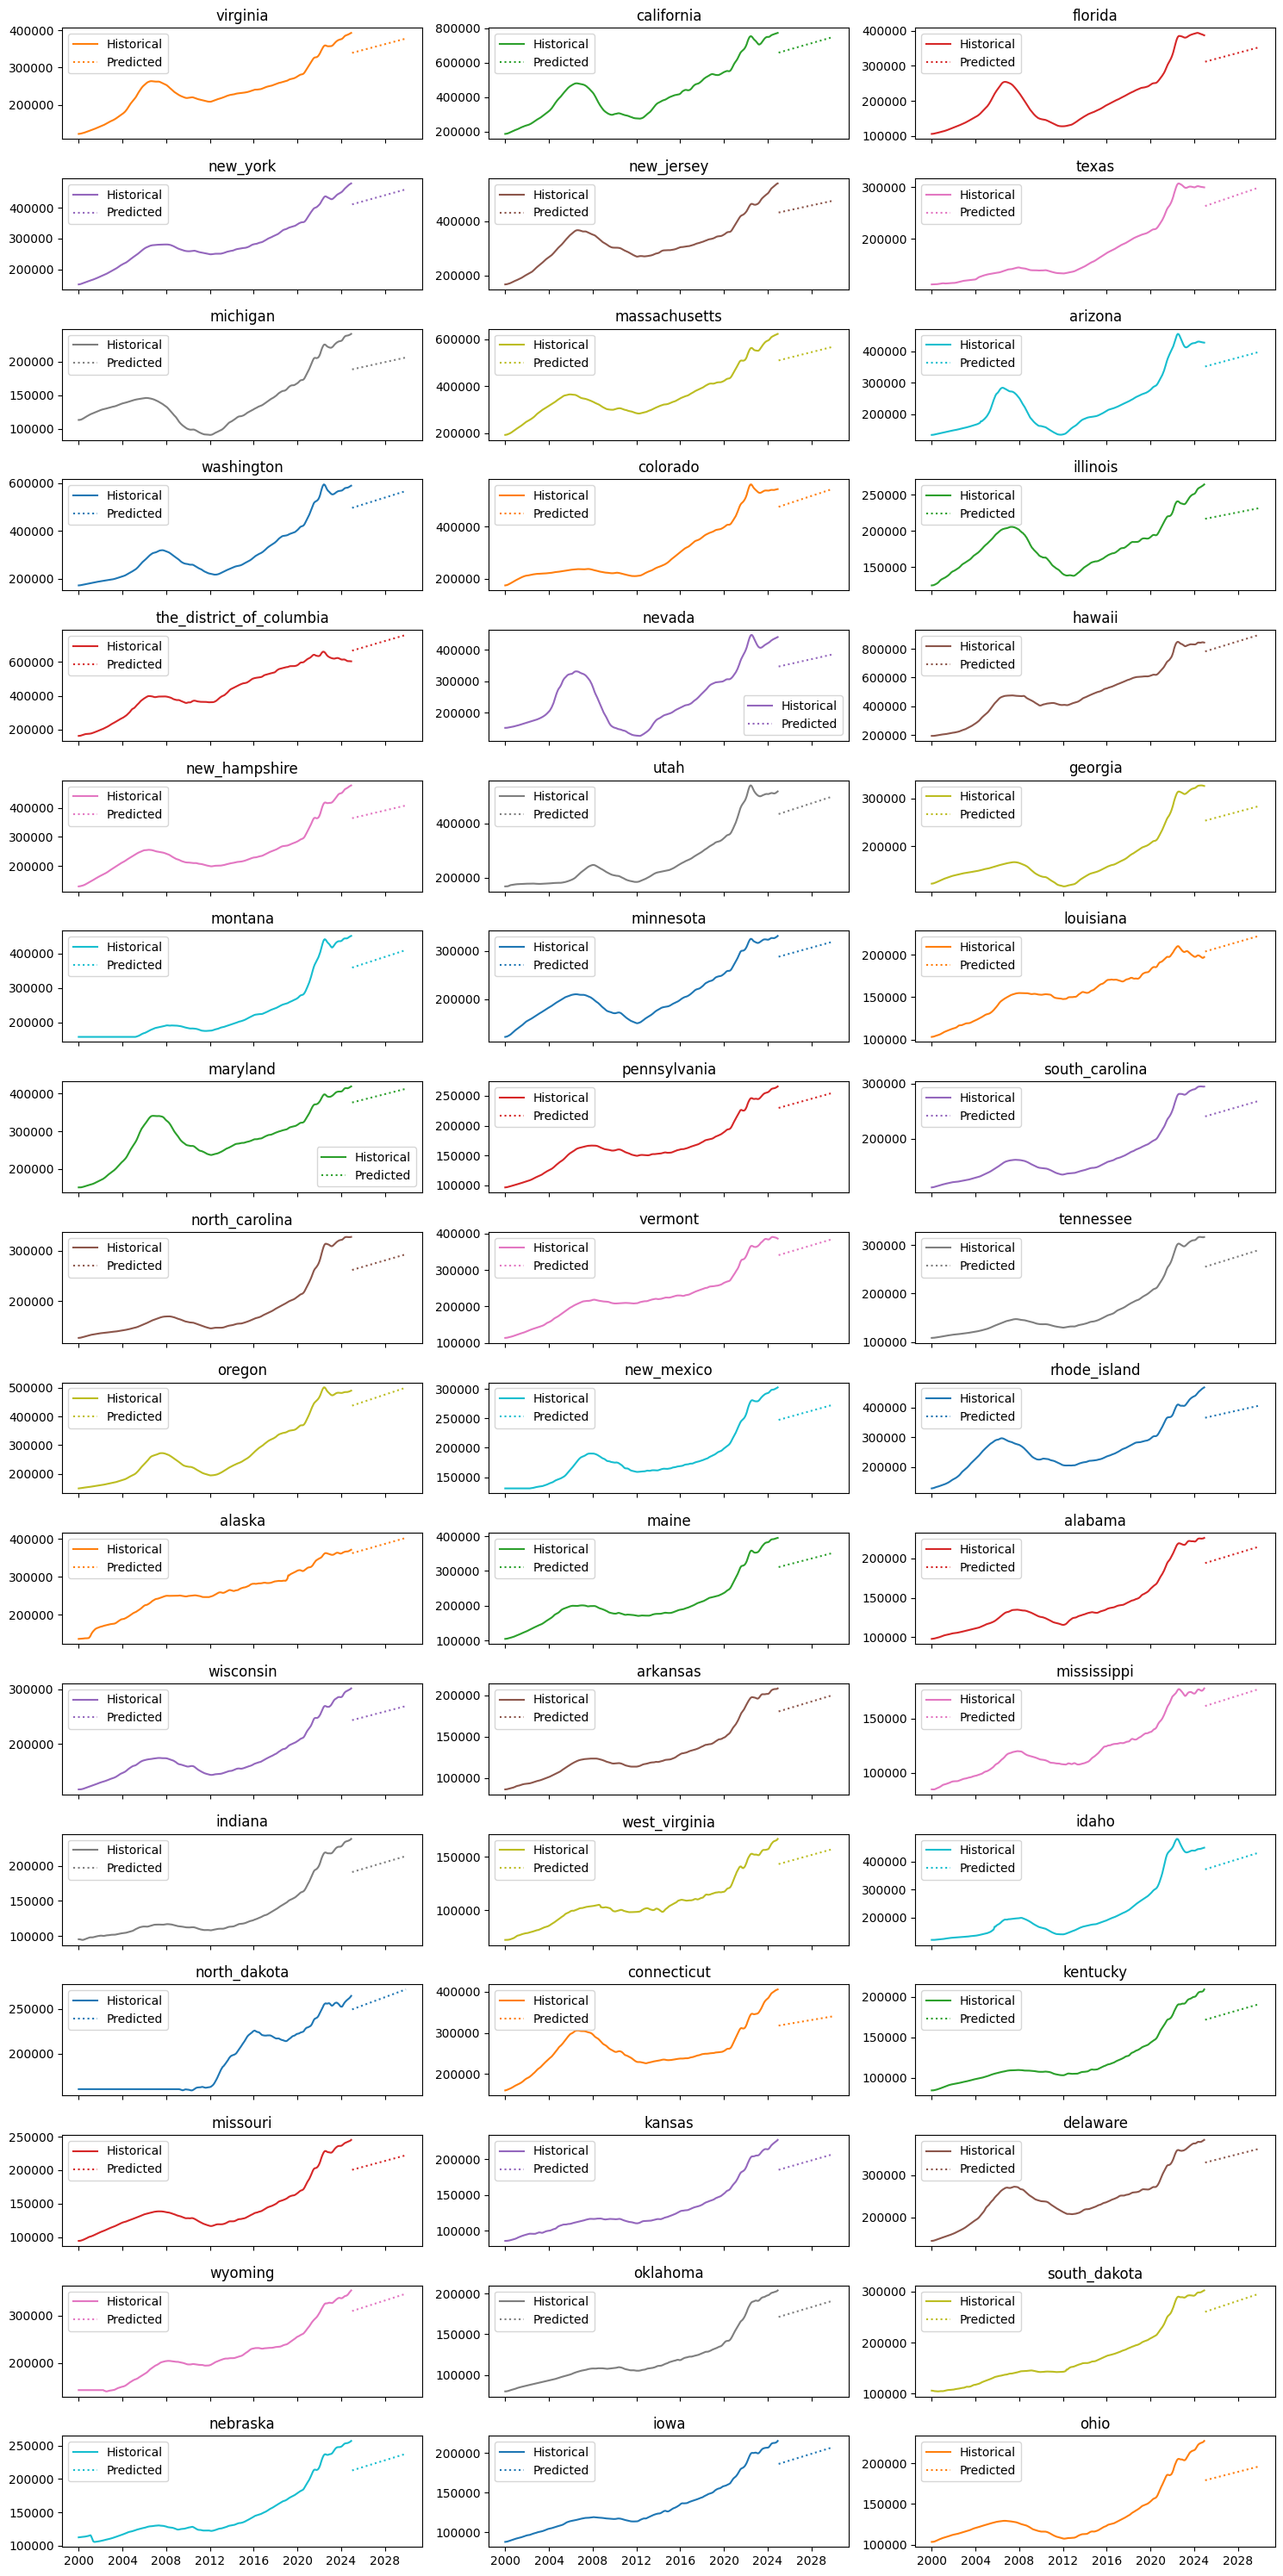

In [362]:
fig, axs = plt.subplots(17, 3, figsize=(15, 30), sharex=True, sharey=False)
axs = axs.flatten()

largest_future_change = float("-inf")
largest_future_change_state = ""
smallest_future_change = float("inf")
smallest_future_change_state = ""

largest_current_change = float("-inf")
largest_current_change_state = ""
smallest_current_change = float("inf")
smallest_current_change_state = ""

months = 60

for i, state in enumerate(states):
    X = np.arange(len(df[state])).reshape(-1, 1)  # use .reshape(-1, 1) so the date stays the same but it's a 2D array, instead of a 1D array
    y = df[state].values
    
    model = LinearRegression()
    model.fit(X, y)

    last_date = df[state].index[-1]
    future_dates = add_months(last_date, months)
    future_X = np.arange(len(df[state]), len(df[state]) + months).reshape(-1, 1)
    future_y = model.predict(future_X)

    """
    concatenate vs union:
    pd.union: Combines two indexes or sets while removing duplicates and sorting the result (unless you specify sort=False.
    - good for dates.
    np.concatenate: Combines two or more arrays along a specified axis.
    - good for combining data from multiple arrays.
    """

    all_X = df[state].index.union(future_dates)
    all_y = np.concatenate([df[state].values, future_y])

    future_change = round((future_y[-1] - df[state][last_date]) / df[state][last_date] * 100, 2)
    current_change = round(df[state][df[state].last_valid_index()] - df[state][df[state].first_valid_index()] / df[state][df[state].first_valid_index()] * 100, 2)
    if future_change > largest_future_change:
        largest_future_change = future_change
        largest_future_change_state = state
    if future_change < smallest_future_change:
        smallest_future_change = future_change
        smallest_future_change_state = state
    if current_change > largest_current_change:
        largest_current_change = current_change
        largest_current_change_state = state
    if current_change < smallest_current_change:
        smallest_current_change = current_change
        smallest_current_change_state = state

    color = next(colors)
    axs[i].plot(df[state].index, df[state].values, label="Historical", color=color)
    axs[i].plot(future_dates, future_y, label="Predicted", linestyle=":", color=color)
    axs[i].set_title(state)
    axs[i].legend()

plt.tight_layout()
plt.show()

Notice how the predicted values all seem to be lower than the most recent historical values. This might mean that house prices have risen too quickly, and if you look at the data between 2020 and 2024 it seems to be right. The predicted values fall more in line with the data from 2012 to 2020 because that data is much more linear and extrapolated would fall almost identical to the predicted line.

## Answers

Now that we have our data and plots, let's answer the questions we asked at the beginning:

In [363]:
print("The state with the greatest predicted increase in price for the next 5 years is:", largest_future_change_state)
print("The state with the smallest predicted increase in price for the next 5 years is:", smallest_future_change_state)
print("The state with the greatest historical increase in price is:", largest_current_change_state)
print("The state with the smallest historical increase in price is:", smallest_current_change_state)

The state with the greatest predicted increase in price for the next 5 years is: the_district_of_columbia
The state with the smallest predicted increase in price for the next 5 years is: connecticut
The state with the greatest historical increase in price is: hawaii
The state with the smallest historical increase in price is: west_virginia


With this the data analysis is complete.

Some other questions you can ask and answer are:

- What is the average price of a house historically?
- How much are houses expected to rise in price over the next 5 years?